# CW 10 Part 2


In this coursework, we aim to create a binary intensity distribution that can be generated with a DMD to create a desired complex field distribution after filtering the 1st diffraction order and free space propagation. This approach called Lee hologram method can be visualized as

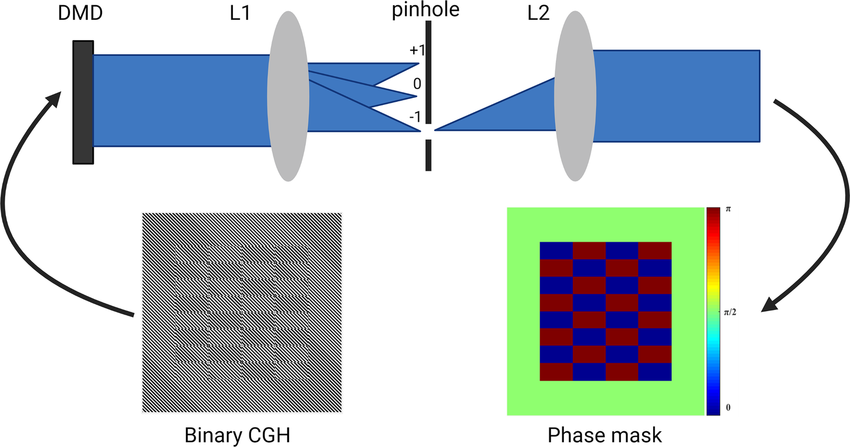

Consider the same setting as in the Part 1 in reverse; after going through a 4f system with M = 1 and off-axis filtering, the recording screen is at z = 3 cm. Find the input binary amplitude pattern to have the padded cameraman image as the phase on the screen plane.

Confirm the found binary phase pattern by forward propagating the pattern.

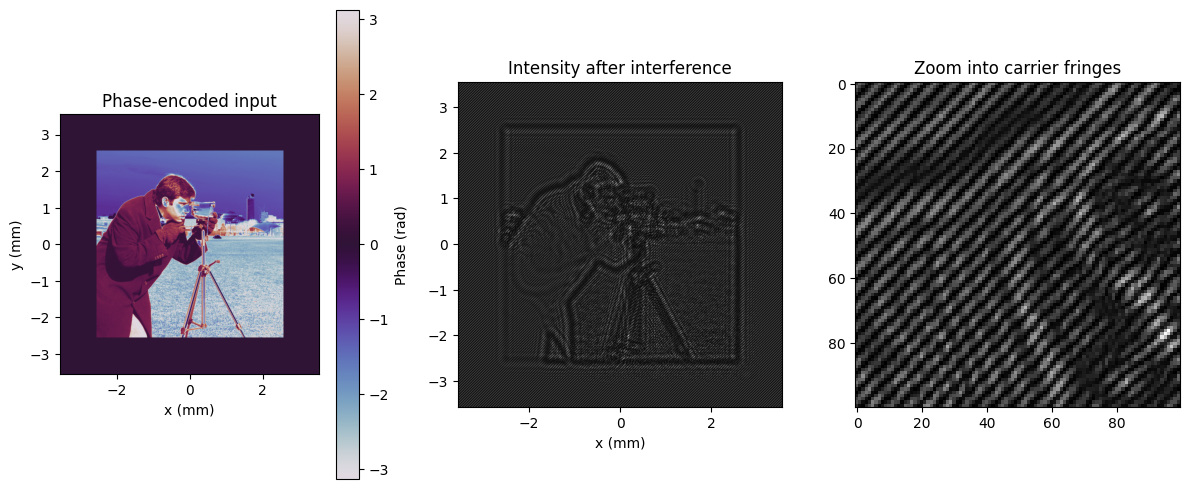

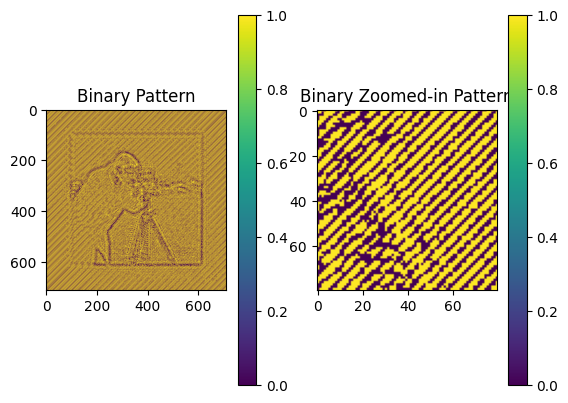

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from scipy.fft import fft2, ifft2, fftshift

img = data.camera()
# pad the image
img = np.pad(img, ((100, 100), (100, 100)), mode='constant')
img = img / 255.0  # Normalize to [0, 1]
ny, nx = img.shape
dx = dy = 10e-6  # Pixel size (10 microns)

phase = img * 2 * np.pi  # scale to [0, 2pi]
field = np.exp(1j * phase)  # complex field with phase encoding

def fresnel_propagate(u0, z, wavelength, dx):
    k = 2 * np.pi / wavelength
    ny, nx = u0.shape
    fx = np.fft.fftfreq(nx, d=dx)
    fy = np.fft.fftfreq(ny, d=dx)
    FX, FY = np.meshgrid(fx, fy)
    H = np.exp(-1j * np.pi * wavelength * z * (FX**2 + FY**2))
    U0 = fft2(u0)
    Uz = ifft2(U0 * H)
    return Uz

wavelength = 633e-9  # 633 nm (red laser)
z = 0.03  # propagation distance in meters (1 cm)
propagated_field = fresnel_propagate(field, -z, wavelength, dx)

theta_x = 3 * np.pi / 180  # 5 degrees off-axis
theta_y = 3 * np.pi / 180  # 5 degrees off-axis

kx = (2 * np.pi / wavelength) * np.sin(theta_x)
ky = (2 * np.pi / wavelength) * np.sin(theta_y)

x = (np.arange(nx) - nx // 2) * dx
y = (np.arange(ny) - ny // 2) * dy
X, Y = np.meshgrid(x, y)
plane_wave = np.exp(1j * ((kx * X)+ (ky * Y)) )

interfered = propagated_field + plane_wave
intensity = np.abs(interfered) ** 2
max_int = intensity.max()
min_int = intensity.min()
norm_intensity = (intensity - min_int) / (max_int - min_int)
binary_intensity = np.where(norm_intensity > 0.1, 1, 0)

plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.title("Phase-encoded input")
plt.imshow(np.angle(field), cmap='twilight', extent=[x[0]*1e3, x[-1]*1e3, y[0]*1e3, y[-1]*1e3])
plt.colorbar(label="Phase (rad)")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")

plt.subplot(1, 3, 2)
plt.title("Intensity after interference")
plt.imshow(intensity, cmap='gray', extent=[x[0]*1e3, x[-1]*1e3, y[0]*1e3, y[-1]*1e3])
plt.xlabel("x (mm)")

plt.subplot(1, 3, 3)
plt.title("Zoom into carrier fringes")
plt.imshow(intensity[200:300, 200:300], cmap='gray')
plt.tight_layout()
plt.show()

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(binary_intensity); plt.colorbar(); plt.title('Binary Pattern')
plt.subplot(1, 2, 2)

plt.imshow(binary_intensity[400:480,400:480]); plt.title('Binary Zoomed-in Pattern'); plt.colorbar(); plt.show()




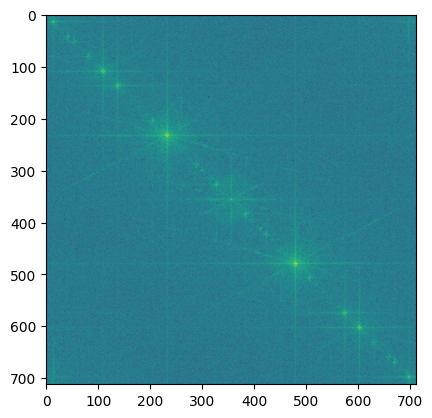

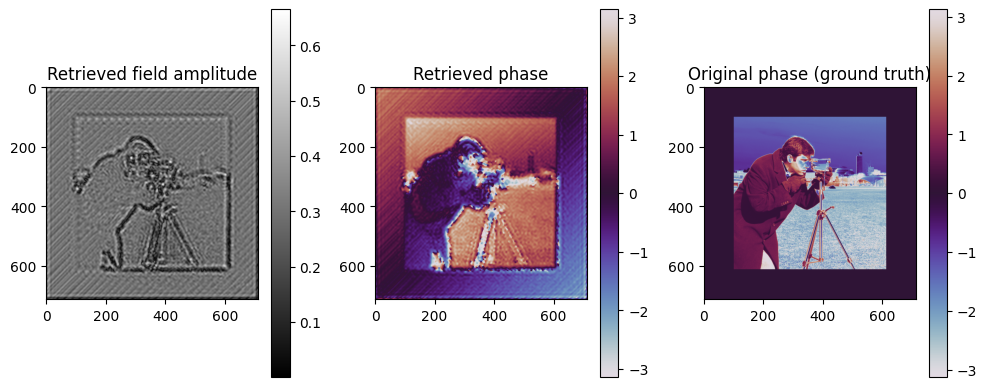

In [ ]:
# forward propagate the binary pattern
I_fft = fftshift(fft2(binary_intensity))
magnitude_spectrum = np.abs(I_fft)

plt.imshow(np.log(magnitude_spectrum)); plt.show


cy, cx = ny // 2, nx // 2
center_order= 233
range = 64
off_axis_peak = I_fft[center_order-range:center_order+range,center_order-range:center_order+range]  # adjust if needed
windowed = np.zeros_like(I_fft, dtype=complex)
windowed[cy-range:cy+range, cx-range:cx+range] = off_axis_peak

retrieved_field = ifft2(fftshift(windowed))

retrieved_backprop = fresnel_propagate(retrieved_field, z, wavelength, dx)

plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.title("Retrieved field amplitude")
plt.imshow(np.abs(retrieved_backprop), cmap='gray')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Retrieved phase")
plt.imshow(np.angle(retrieved_backprop), cmap='twilight')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Original phase (ground truth)")
plt.imshow(np.angle(field), cmap='twilight')
plt.colorbar()

plt.tight_layout()
plt.show()
